# FYS4565 -- Example using the BeamlineElements and BeamLine library

The `BeamLineElements` library` helps you create 2x2 or 6x6 matrices, which are very useful for linear optics calculations in particle accelerators.

This can be combined with the `BeamLine`` library, which keeps track of sequences of such elements.


In [12]:
#Import library and pretty-printing tool
import BeamlineElements
import BeamLine
import Util

In this example, we will look at one FODO cell of a particle accelerator.
In this lattice, the optics functions will repeat after a distance $L = 106.90$ [m], and the focal length of the quadrupoles (alternating focusing and defocusing in the horizontal plane) is $f=38$ [m].
We will look at what happens during one single period, starting from the middle of a horizontally focusing magnet.

In this case we will only look at the horizontal plane, and use the thin-lens approximation.

In [13]:
#Create a simple FODO lattice
# 2D in the thin-lens approximation
L_FODO = 106.90 #[m]
f      = 38     #[m]

MQf2 = BeamlineElements.MakeElemMatrix2D_QuadThin(+f*2) # Half the magnet
MQd  = BeamlineElements.MakeElemMatrix2D_QuadThin(-f)
Md   = BeamlineElements.MakeElemMatrix2D_Drift(L_FODO/2)


Two equivalent ways of finding the combined transformation matrix

In [14]:
# Direct matrix multiplication
Mfodo = MQf2 @ Md @ MQd @ Md @ MQf2
Util.printMatrixAll(Mfodo)

 [i,j] |      j = 0          1 
-------|-----------------------
 i = 0 |  1.077e-02  1.821e+02 
     1 | -5.491e-03  1.077e-02 


In [15]:
# Using the BeamLine.ElementSequence class
BL = BeamLine.ElementSequence(is2D=True)
BL.appendElement(MQf2)
BL.appendElement(Md)
BL.appendElement(MQd)
BL.appendElement(Md)
BL.appendElement(MQf2)

print(BL)

Util.printMatrixAll(BL.getCombinedTransform())

ElementSequence:
 - is2D = True
 - hasElementLengths = False
 BeamLineElements contained within:
 Elem #0/5:
 1.000e+00  0.000e+00 
-1.316e-02  1.000e+00 
 Elem #1/5:
 1.000e+00  5.345e+01 
 0.000e+00  1.000e+00 
 Elem #2/5:
 1.000e+00  0.000e+00 
 2.632e-02  1.000e+00 
 Elem #3/5:
 1.000e+00  5.345e+01 
 0.000e+00  1.000e+00 
 Elem #4/5:
 1.000e+00  0.000e+00 
-1.316e-02  1.000e+00 
 [i,j] |      j = 0          1 
-------|-----------------------
 i = 0 |  1.077e-02  1.821e+02 
     1 | -5.491e-03  1.077e-02 


Let's now send a single particle through 8 cells, with initial position 1 mm and initial angle x' = 0

Initial X =
 [[0.001]
 [0.   ]]
After tracking, X_log[coord,time] = 
 [i,j] |      j = 0          1          2          3          4          5          6          7          8 
-------|----------------------------------------------------------------------------------------------------
 i = 0 |  1.000e-03  1.077e-05 -9.998e-04 -3.230e-05  9.991e-04  5.381e-05 -9.979e-04 -7.530e-05  9.963e-04 
     1 |  0.000e+00 -5.491e-06 -1.183e-07  5.489e-06  2.365e-07 -5.484e-06 -3.546e-07  5.476e-06  4.725e-07 


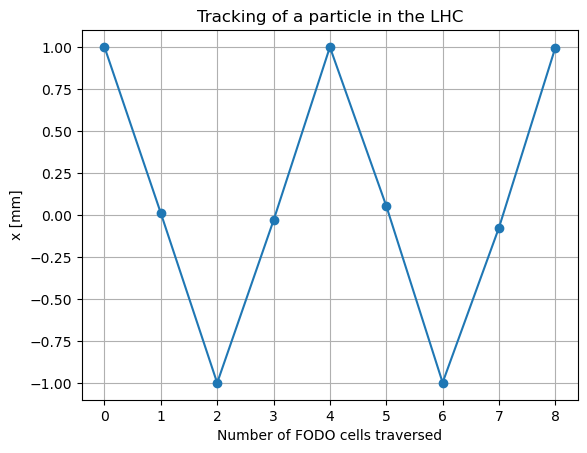

In [16]:
x0  = 1e-3 #[m]
xp0 = 0.0  #[1]
X = np.asarray([[x0],[xp0]])
print(f'Initial X =\n {X}')

Ncells = 8
X_log = np.zeros((2,Ncells+1)) #To be used for logging the position in phase space after each cell
X_log[:,0] = X[:,0]

for i in range(Ncells):
    X=Mfodo@X
    X_log[:,i+1] = X[:,0]

print('After tracking, X_log[coord,time] = ')
Util.printMatrixAll(X_log)

plt.figure()
plt.plot(X_log[0,:]*1e3, '-o')
plt.xlabel('Number of FODO cells traversed')
plt.ylabel('x [mm]')
plt.title('Tracking of a particle in the LHC')
plt.grid(True)
plt.show()

But what is happening inside a single cell? Let's investigate:

 [i,j] |      j = 0          1          2          3          4          5 
-------|-------------------------------------------------------------------
 i = 0 |  1.000e-03  1.000e-03  2.967e-04  2.967e-04  1.077e-05  1.077e-05 
     1 |  0.000e+00 -1.316e-05 -1.316e-05 -5.350e-06 -5.350e-06 -5.491e-06 


/tmp/ipykernel_323082/3219842159.py:31: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.figlegend([p1,p2], labels=["$x$","$x'$"], ncols=2,loc='upper center')


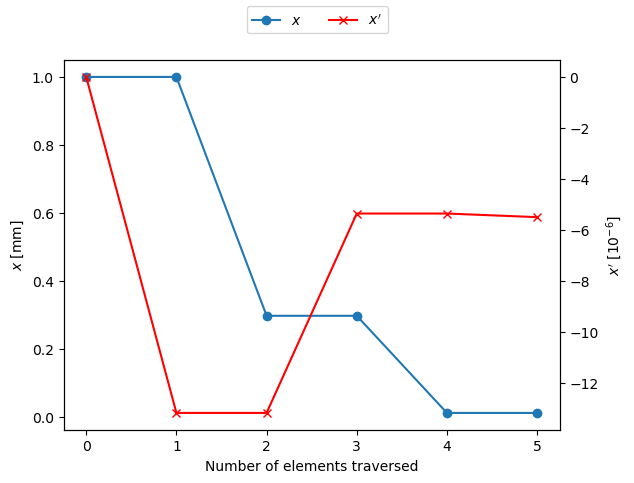

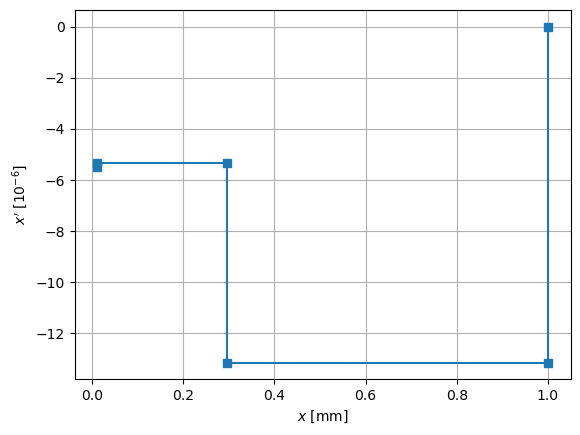

In [45]:
#Direct method
X = np.asarray([[x0],[xp0]])

def trackCell(X0):
    "This function tracks element by element in once cell like the one given above"
    X_log = np.zeros((2,6))
    
    X_log[:,0] = X0[:,0]
    X_log[:,1] = MQf2 @ X_log[:,0]
    X_log[:,2] = Md   @ X_log[:,1]
    X_log[:,3] = MQd  @ X_log[:,2]
    X_log[:,4] = Md   @ X_log[:,3]
    X_log[:,5] = MQf2 @ X_log[:,4]

    return X_log

#Call the tracking routine
X_cellLog = trackCell(X)
#Print the result
Util.printMatrixAll(X_cellLog)

#Plot the resulting x[idx],y[idx] 
plt.figure()
p1 = plt.plot(X_cellLog[0,:]*1e3, '-o')
plt.xlabel('Number of elements traversed')
plt.ylabel('$x$ [mm]')
plt.twinx()
p2 = plt.plot(X_cellLog[1,:]*1e6, '-x', color='red')
plt.ylabel("$x'$ [$10^{-6}$]")

plt.figlegend([p1,p2], labels=["$x$","$x'$"], ncols=2,loc='upper center')

#Plot the phase space
plt.figure()
plt.plot(X_cellLog[0,:]*1e3,X_cellLog[1,:]*1e6, '-s')
plt.xlabel('$x$ [mm]')
plt.ylabel("$x'$ [$10^{-6}$]")
plt.grid()

plt.show()


The `trackCell()` function worked, but we had to specify each element in a somewhat errorprone way.
However we already have this information in our `ElementSequence` object BL, why not just use it?

In [ ]:
#Same as above, but use the elementSequence